In [1]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
spark = SparkSession.builder.appName('sharingBikeDatamining').getOrCreate()

#conf = SparkConf().setAppName('sharingBikeDatamining').setMaster('local[2]')
#sc = SparkContext(conf=conf)

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [3]:
dailyData = pd.read_csv('/home/ubuntu/sharing-bike-data-mining/hour.csv')

In [4]:
# variables data type
dailyData.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## 2.1 -- 2.3 Data exploration

In [5]:
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weathersit"] = dailyData.weathersit.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [6]:
dailyData.describe()

,instant,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [7]:
#Coercing To Category Type
categoryVariableList = ["hr","weekday","mnth","season","weathersit","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

[Text(0,0.5,'Count'),
 Text(0.5,0,'variableTypeariable Type'),
 Text(0.5,1,'Variables DataType Count')]

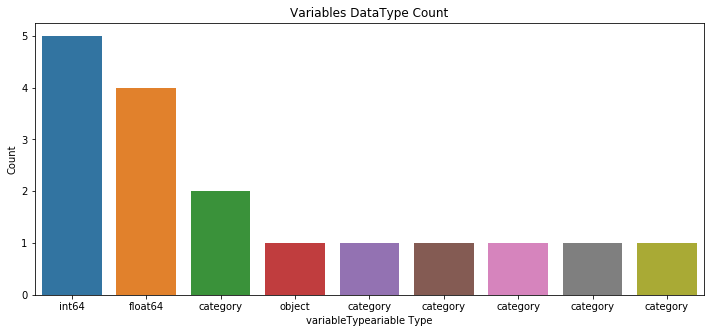

In [8]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

[Text(0,0.5,'count'),
 Text(0.5,0,'season'),
 Text(0.5,1,'Bar Plot On Count Across Season')]

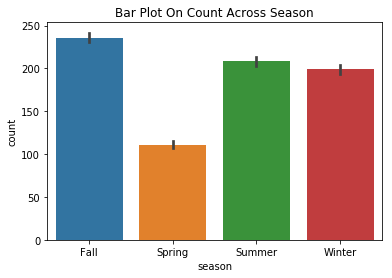

In [9]:
fig,ax = plt.subplots()
sn.barplot(data=dailyData,x="season",y="cnt",ax=ax)
ax.set(xlabel='season', ylabel='count',title="Bar Plot On Count Across Season")

[Text(0,0.5,'count'),
 Text(0.5,0,'weathersit'),
 Text(0.5,1,'Bar Plot On Count Across weathersit')]

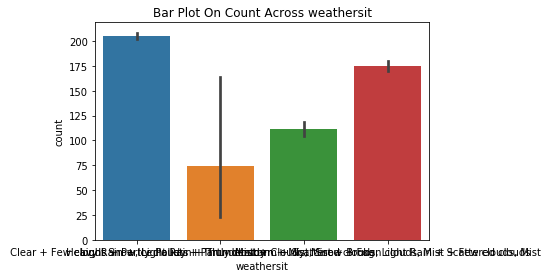

In [10]:
fig,ax = plt.subplots()
sn.barplot(data=dailyData,x="weathersit",y="cnt",orient="v", ax=ax)
ax.set(xlabel='weathersit', ylabel='count',title="Bar Plot On Count Across weathersit")

[Text(0,0.5,'count'),
 Text(0.5,0,'workingday'),
 Text(0.5,1,'Bar Plot On Count Across workingday')]

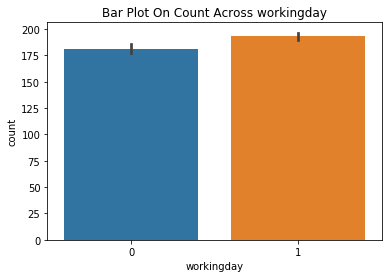

In [11]:
fig,ax = plt.subplots()
sn.barplot(data=dailyData,x="workingday",y="cnt",orient="v", ax=ax)
ax.set(xlabel='workingday', ylabel='count',title="Bar Plot On Count Across workingday")

## 2.4 Verify the data quality

### missing value

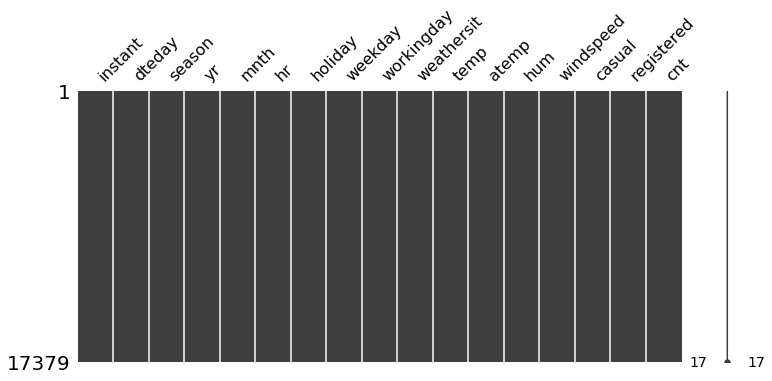

In [12]:
# missing value detect
msno.matrix(dailyData,figsize=(12,5))

### data outliers

[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

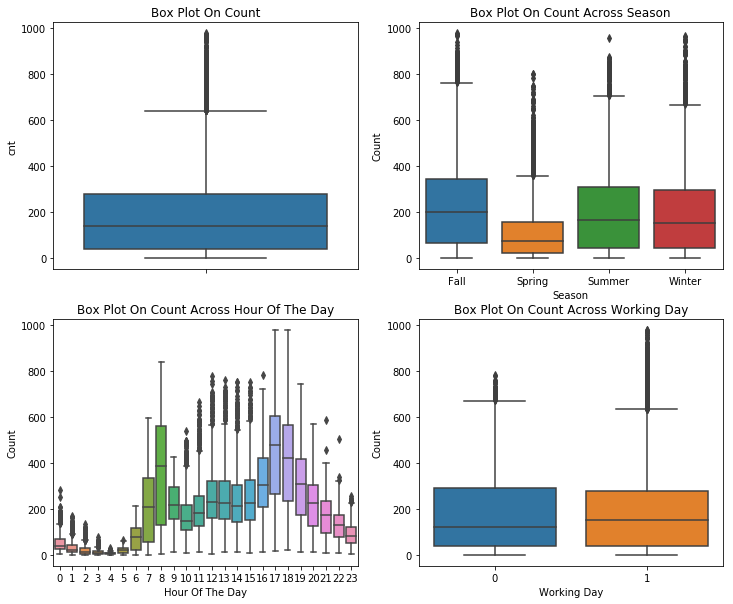

In [13]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="cnt",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="cnt",x="hr",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='cnt',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

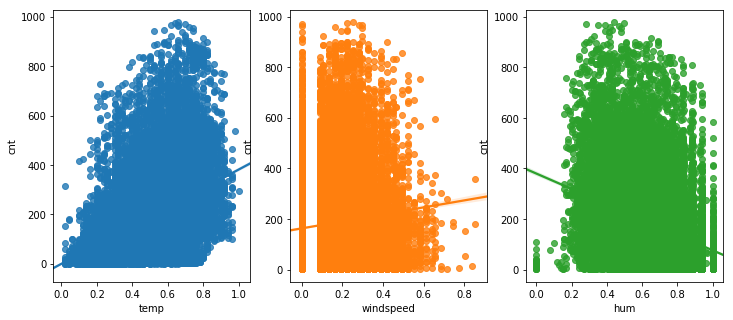

In [14]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=dailyData,ax=ax2)
sn.regplot(x="hum", y="cnt", data=dailyData,ax=ax3)

In [15]:
#  Remove Outliers In The Count Column and wind speed column
dailyDataWithoutOutliers1 = dailyData[np.abs(dailyData["cnt"]-dailyData["cnt"].mean())<=(3*dailyData["cnt"].std())] 
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers1.shape)

dailyDataWithoutOutliers2 = dailyDataWithoutOutliers1[np.abs(dailyData["windspeed"]-dailyData["windspeed"].mean())<=(3*dailyData["windspeed"].std())]
dailyDataWithoutOutliers3 = dailyDataWithoutOutliers2[np.abs(dailyData["windspeed"]-dailyData["windspeed"].mean())<=(3*dailyData["windspeed"].std())]
print ("Shape Of The Before Ouliers: ",dailyDataWithoutOutliers1.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers3.shape)

Shape Of The Before Ouliers:  (17379, 17)
Shape Of The After Ouliers:  (17135, 17)
Shape Of The Before Ouliers:  (17135, 17)
Shape Of The After Ouliers:  (17029, 17)


/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


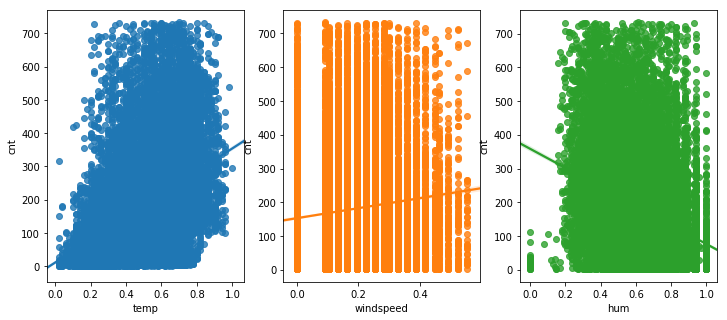

In [16]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=dailyDataWithoutOutliers3,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=dailyDataWithoutOutliers3,ax=ax2)
sn.regplot(x="hum", y="cnt", data=dailyDataWithoutOutliers3,ax=ax3)

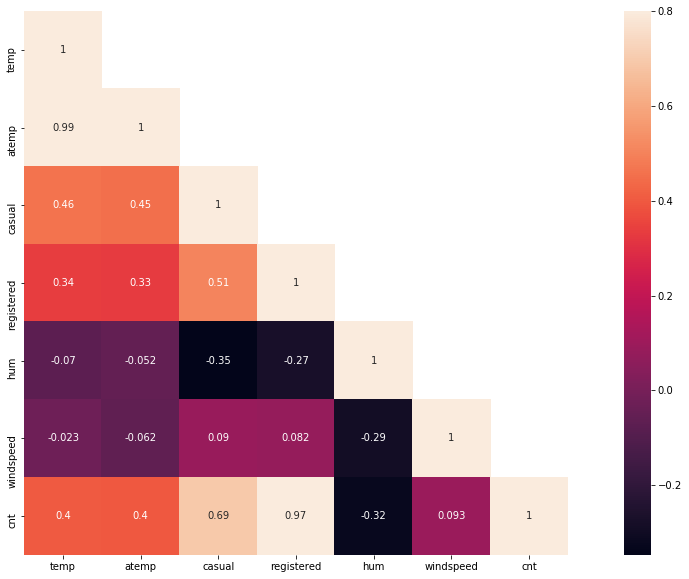

In [17]:
# Correlation Analysis
corrMatt = dailyData[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [18]:
dailyDataWithoutOutliers3.describe()

,instant,yr,temp,atemp,hum,windspeed,casual,registered,cnt
count,17029.00000,17029.000000,17029.000000,17029.000000,17029.000000,17029.000000,17029.000000,17029.000000,17029.000000
mean,8623.16883,0.495331,0.494830,0.474012,0.629856,0.187165,34.870456,145.787480,180.657936
std,5007.49772,0.499993,0.192322,0.171555,0.192306,0.117735,48.820804,136.068306,166.348362
min,1.00000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4297.00000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,33.000000,39.000000
50%,8566.00000,0.000000,0.500000,0.484800,0.630000,0.164200,16.000000,113.000000,139.000000
75%,12924.00000,1.000000,0.640000,0.621200,0.790000,0.253700,47.000000,214.000000,274.000000
max,17379.00000,1.000000,1.000000,1.000000,1.000000,0.552200,367.000000,712.000000,733.000000


## Normolize Data

((array([-3.94022212, -3.72206536, -3.60260503, ...,  3.60260503,
          3.72206536,  3.94022212]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.5971457 ,
         6.59850903])),
 (1.3505743818579579, 4.5438200650141995, 0.9601862364739593))

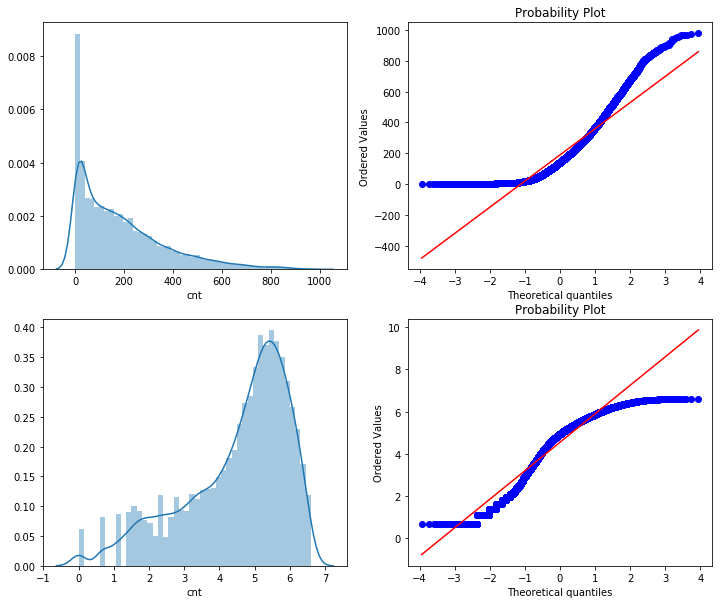

In [19]:

fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["cnt"],ax=axes[0][0])
stats.probplot(dailyData["cnt"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers3["cnt"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers3["cnt"]), dist='norm', fit=True, plot=axes[1][1])

In [20]:
dailyData["season"] = dailyData.season.map({ "Spring" : 1, "Summer" : 2, "Fall" : 3, "Winter" : 4 })

dailyData["weathersit"] = dailyData.weathersit.map({ " Clear + Few clouds + Partly cloudy + Partly cloudy" : 1,\
                                       " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist " : 2, \
                                       " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds" : 3, \
                                       " Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " : 4 })

## Select Data

### convert panadas data frame into spark data frame

In [21]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
sqlContext = SQLContext(spark)
spark_dailyData = sqlContext.createDataFrame(dailyData)

vectorAssembler = VectorAssembler(inputCols = ['season', 'holiday', 'weekday', 'workingday', 
                                               'weathersit', 'temp', 'windspeed', 'casual', 'registered'],
                                  outputCol = 'features')
sharingbike_model_matrix = vectorAssembler.transform(spark_dailyData)

sharingbike_model_matrix = sharingbike_model_matrix.select(['features', 'cnt'])
sharingbike_model_matrix.printSchema()


root
 |-- features: vector (nullable = true)
 |-- cnt: long (nullable = true)



## Spliting data into test data and train data

In [22]:
splits = sharingbike_model_matrix.randomSplit([0.5, 0.5])

train_df = splits[0]
test_df = splits[1]

train_df.describe().show()
test_df.describe().show()

+-------+------------------+
|summary|               cnt|
+-------+------------------+
|  count|              8761|
|   mean|187.89259216984362|
| stddev|  180.199711611814|
|    min|                 1|
|    max|               976|
+-------+------------------+

+-------+------------------+
|summary|               cnt|
+-------+------------------+
|  count|              8618|
|   mean|191.05964260849385|
| stddev|182.58388593340152|
|    min|                 1|
|    max|               977|
+-------+------------------+



## Linear Regression
#### building model

In [23]:
from pyspark.ml.regression import LinearRegression
# Instantiate the instance.
# 
lr = LinearRegression(featuresCol='features', labelCol='cnt', maxIter=15, regParam=0.9, elasticNetParam=0.5)

# elasticNetParam ---> alpha: 0-ridge;1-lasso;
# Fit the training data.
lr_model = lr.fit(train_df)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarize the model over the training set and print out some metrics
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9957831774807293,0.9952147309626902]
Intercept: 0.8792401162245698

RMSE: 0.843615
r2: 0.999978


##### R squared at 0.99 indicates that in our model, approximate 99% of the variability in "sharing bike using number" can be explained using the model. This is not bad.

In [24]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","cnt","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="")

+------------------+---+--------------------+
|        prediction|cnt|            features|
+------------------+---+--------------------+
|  1.87445484718726|  1|(9,[0,4,5,8],[1.0...|
|3.8648843091126404|  3|(9,[0,4,5,8],[1.0...|
| 6.850528502000711|  6|(9,[0,4,5,8],[1.0...|
| 5.855313771038021|  5|(9,[0,4,5,8],[1.0...|
| 52.63040612628446| 52|(9,[0,4,5,8],[1.0...|
+------------------+---+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.999978


In [25]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

numIterations: 16
objectiveHistory: [0.4999999999999999, 0.37651827682305383, 0.025749939594762468, 0.011915807764447433, 0.004182213662301017, 0.0038175805985892017, 0.003755928139113098, 0.0037172405950897137, 0.0037175215912587274, 0.0037141083295293893, 0.0037139613638325136, 0.00371381484849638, 0.0037138086231745734, 0.0037138049797278356, 0.0037138047695902763, 0.003713804641487581]


## Desicion Tree Regression

In [32]:
from  pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'cnt', maxBins = 200, maxDepth = 30)

dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_evaluator = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)
print("R Squared  on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 7.75324
R Squared  on test data = 0.998197


In [29]:
dt_predictions.select("features","cnt","prediction").show(3)

+--------------------+---+----------+
|            features|cnt|prediction|
+--------------------+---+----------+
|(9,[0,4,5,8],[1.0...|  1|       1.0|
|(9,[0,4,5,8],[1.0...|  3|       3.0|
|(9,[0,4,5,8],[1.0...|  6|       6.0|
+--------------------+---+----------+
only showing top 3 rows



In [38]:
dt_model.featureImportances

SparseVector(9, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0001, 6: 0.0001, 7: 0.0548, 8: 0.9449})

In [40]:
spark_dailyData.take(1)

[Row(instant=1, dteday='2011-01-01', season=1, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16)]

In [35]:
print(dt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: variance (default: variance)
labelCol: label column name. (default: label, current: cnt)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32, current: 200)
maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 

## Gradient-boosted tree regression

In [33]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'cnt', maxIter=20)

gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
#gbt_predictions.select('prediction', 'cnt', 'features').show(5)
gbt_evaluator  = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
gbt_evaluator  = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
print("R Squared  on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 18.8947
R Squared  on test data = 0.98929


## Visuallization

[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

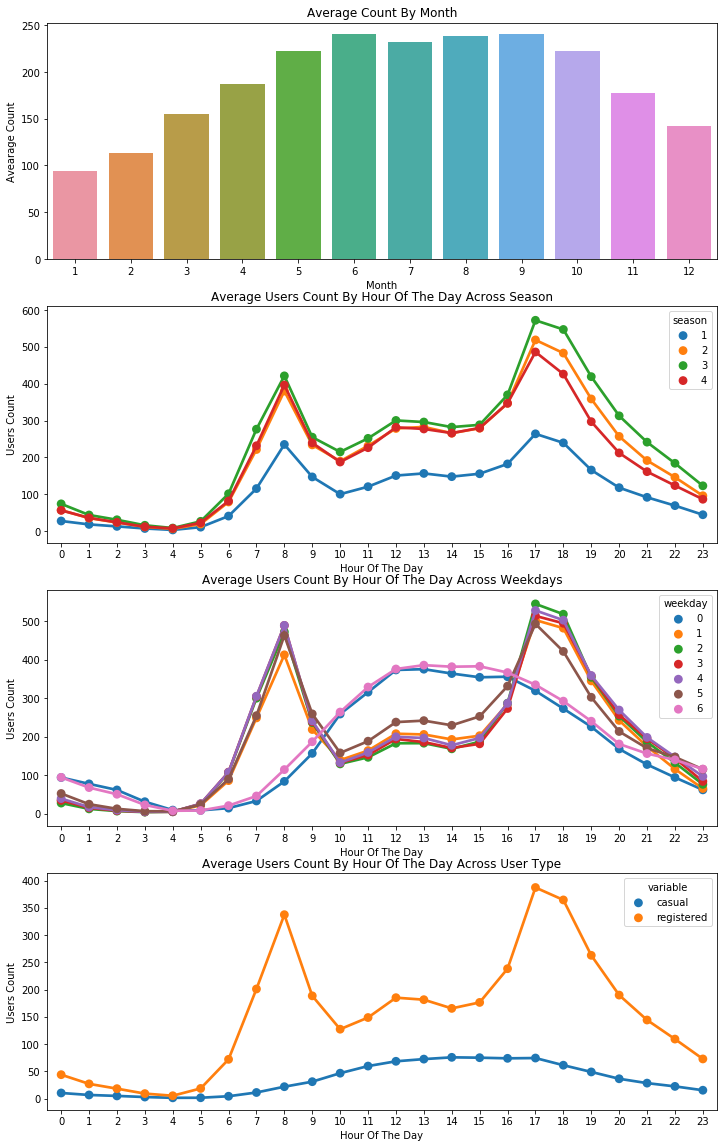

In [41]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

### ax 1 ###
monthAggregated = pd.DataFrame(dailyData.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=monthSorted,x="mnth",y="cnt", ax = ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

### ax 2 ###
hourAggregated = pd.DataFrame(dailyData.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

## ax 3 ###
hourAggregated = pd.DataFrame(dailyData.groupby(["hr","weekday"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y = hourAggregated["cnt"],hue = hourAggregated["weekday"], data = hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

## ax 4 ###
hourTransformed = pd.melt(dailyData[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["value"],hue=hourAggregated["variable"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')